In [ ]:
!nvidia-smi

Wed Jul 14 17:35:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    33W /  70W |    660MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install keras==2.3.1

In [ ]:
# import tensorflow.keras as keras
import numpy as np
import os
import random

! pip install keras-tuner
import tensorflow as tf
import numpy as np
import os
import random
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPool1D, LSTM, MaxPool1D
from tensorflow.keras.layers import ReLU, BatchNormalization, Bidirectional, concatenate, Reshape, TimeDistributed
from tensorflow.keras.layers import Conv2D, ConvLSTM2D, MaxPool2D, SpatialDropout2D, Softmax, ELU, Layer, Masking
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPool2D, LeakyReLU, LSTMCell, RNN, InputSpec
from tensorflow.keras.layers import concatenate, Conv1DTranspose, Conv2DTranspose, Flatten, StackedRNNCells
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow import keras as keras
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from matplotlib import pyplot as plt
import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization, Hyperband
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Permute, multiply, Activation
import tensorflow.keras.backend as K

from tensorflow.keras import backend as K
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints


In [ ]:
def load_X(path):
    X_signals = []
    files = os.listdir(path)
    files.sort(key=str.lower)
    #['train_acc_x.txt', 'train_acc_y.txt', 'train_acc_z.txt', 'train_gyr_x.txt', 'train_gyr_y.txt', 'train_gyr_z.txt']
    for my_file in files:
        fileName = os.path.join(path,my_file)
        file = open(fileName, 'r')
        X_signals.append(
            [np.array(cell, dtype=np.float32) for cell in [
                row.strip().split(' ') for row in file
            ]]
        )
        file.close()
        #X_signals = 6*totalStepNum*128
    X_signals = np.transpose(np.array(X_signals), (1, 0, 2))#(totalStepNum*6*128)
    return X_signals.reshape(-1,6,128,1)#(totalStepNum*6*128*1)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    y_ = y_ - 1
    #one_hot
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


def weight_variable(shape):
    initial = tf.random.truncated_normal(shape, std_dev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

batch_size = 512
num_classes = 118

In [ ]:
X_train.shape, train_label.shape, X_test.shape, test_label.shape

((33104, 6, 128), (33104, 118), (3740, 6, 128), (3740, 118))

In [ ]:
def tuned_lstm_model(hp):
    # model = Sequential()
    input_seq = Input(shape=(6, 128))
    processed = LSTM(hp.Int('units', min_value=32, max_value=512, step=32), input_shape=(6, 128))(input_seq)
    processed = Dropout(0.5)(processed)
    # x = (Dense(118*8, activation='relu'))(processed)
    # x = (Dense(118*4, activation='relu'))(x)
    processed =ReLU()(processed)
    activated = (Dense(118, activation='softmax'))(processed)
    model = Model(inputs=input_seq, outputs=activated)
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 3*1e-1, 3*1e-2, 3*1e-3, 3*1e-4, 1e-4, 1.0])), \
                  loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [ ]:
tuner = RandomSearch(
    tuned_lstm_model,
    objective='val_accuracy',
    max_trials=10,
    directory='output1',
    project_name='TIFS20')

tuner.search(X_train, train_label, epochs=200, validation_split=0.1, shuffle=True, callbacks=[EarlyStopping(monitor='val_loss', patience=30)])

Trial 10 Complete [00h 03m 51s]
val_accuracy: 0.8882513046264648

Best val_accuracy So Far: 0.9417094588279724
Total elapsed time: 00h 46m 48s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 128)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 448)               1033984   
_________________________________________________________________
dropout (Dropout)            (None, 448)               0         
_________________________________________________________________
re_lu (ReLU)                 (None, 448)               0         
_________________________________________________________________
dense (Dense)                (None, 118)               52982     
Total params: 1,086,966
Trainable params: 1,086,966
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, train_label, validation_split = 0.1, epochs=100, shuffle=True, batch_size=512, callbacks=[EarlyStopping('val_loss', patience=30)])#, callbacks=[es_callback])

Epoch 1/100
59/59 [==============================] - 2s 18ms/step - loss: 0.0207 - accuracy: 0.9936 - val_loss: 0.3048 - val_accuracy: 0.9423
Epoch 2/100
59/59 [==============================] - 1s 10ms/step - loss: 0.0110 - accuracy: 0.9973 - val_loss: 0.3008 - val_accuracy: 0.9429
Epoch 3/100
59/59 [==============================] - 1s 10ms/step - loss: 0.0083 - accuracy: 0.9981 - val_loss: 0.2988 - val_accuracy: 0.9444
Epoch 4/100
59/59 [==============================] - 1s 10ms/step - loss: 0.0074 - accuracy: 0.9982 - val_loss: 0.2958 - val_accuracy: 0.9453
Epoch 5/100
59/59 [==============================] - 1s 10ms/step - loss: 0.0070 - accuracy: 0.9983 - val_loss: 0.2927 - val_accuracy: 0.9456
Epoch 6/100
59/59 [==============================] - 1s 10ms/step - loss: 0.0057 - accuracy: 0.9988 - val_loss: 0.2931 - val_accuracy: 0.9459
Epoch 7/100
59/59 [==============================] - 1s 10ms/step - loss: 0.0052 - accuracy: 0.9989 - val_loss: 0.2944 - val_accuracy: 0.9453
Epoch 

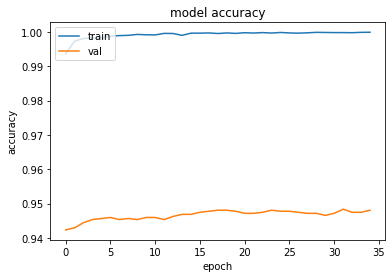

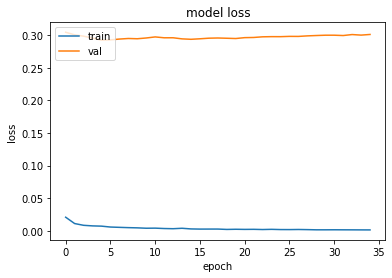

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.2256324291229248
Test accuracy: 0.872459888458252


In [ ]:
model.save('/content/drive/Shareddrives/MMH/models/tuned_lstm_87.h5')

In [ ]:
# Test loss: 0.8689110279083252
# Test accuracy: 0.8852941393852234